## Imports

In [1]:
import os
os.chdir("/Users/aliahmadi/Documents/Projects/RNA-Secondary-Structure-Prediction/notebook/DKH-99")

from collections import defaultdict
from scipy.linalg import expm
from grammar.pcnf import PCNF
from Bio import Phylo, SeqIO
from copy import deepcopy
from io import StringIO
import networkx as nx
from math import log 
import numpy as np
import shutil
import pickle

___

## IUPAC Nucleotide table

In [2]:
iupac_nucleotides = {
    'A':["A"],
    'C':["C"],
    'G':["G"],
    'U':["U"], 
    'R':["A", "G"], 
    'Y':["C", "U"],
    'S':["G", "C"],
    'W':["A", "U"],
    'K':["G", "U"],
    'M':["A", "C"],
    'B':["C", "G", "U"],
    'D':["A", "G", "U"],
    'H':["A", "C", "U"],
    'V':["A", "C", "G"],
    'N':["A", "C", "G", "U"],
    '-': ["-"]
}

## Global Variables

In [3]:
trees = defaultdict(lambda: Phylo.read(StringIO("();"), "newick"))
sequences = defaultdict(lambda: defaultdict(str))
structures = defaultdict(str)

predicted_struct = {}

## Pairing Charecters

In [4]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [5]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [6]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

## Verify Sequences

In [7]:
def is_valid_str(input_string, valid_characters = ['A','C', 'G', 'U']):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

## Read Trees

In [8]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Tree

def open_tree(filename: str, dataset_name):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    
    trees[dataset_name] = Tree

## Read Sequences

In [9]:
def read_sequences (filename: str, dataset_name):
    dataset = defaultdict(str)
    
    with open(filename) as file:
        records = SeqIO.parse(file, "phylip-relaxed")
        count = 0
        
        for record in records:
            dataset[record.id] = record.seq
            count += 1
           
        dataset["_weight"] = 1000 / count   
        
    sequences[dataset_name] = dataset

## Read Structures

In [10]:
def read_structure(filename: str, dataset_name):
    with open(filename) as file:
        structures[dataset_name] = file.readline().strip()

## Simplify Structure

In [11]:
def simplify_struct(structures, filename="./primaries/structures"):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for _, structure in structures.items():
        for i in range(len(structure)):
            if structure[i] in pairing_chars:
                simplified += "d "
            else:
                simplified += "s "
        simplified += "\n"
    
    simplified = simplified.rstrip('\n')
    
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)

## Create Tree

In [12]:
def create_tree(input_sequences, filename = "./outputs/tree.nwk", draw=True):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("./tmp")

  if len(names) > 2:
    phylip_file = "./tmp/sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    !./phyml -i tmp/sequences.phylip -m GTR
    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree("./tmp")
  Phylo.write(output_tree, filename, "newick")
  
  Phylo.draw(output_tree)
  
  return output_tree

## Calculate Frequencies

In [13]:
def calc_frequencies (sequences, structures):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    # Stack of unpaired nucleotides (structure symbol, nocleotide)
    unpaired_nucleotides = []
    for dataset_name, dataset_values in sequences.items():
        sequences_weight = dataset_values["_weight"]
        dataset_sequences = [v for k, v in dataset_values.items() if k != "_weight"]
        dataset_structure = structures[dataset_name]
        for sequence in dataset_sequences:
            for index, nucleotide in enumerate(sequence): 
                structure_symbol = dataset_structure[index]
                # Having a charecter [ '(', '[', '{', '<' ]
                if is_pair_start(structure_symbol):
                    unpaired_nucleotides.append((structure_symbol, iupac_nucleotides[nucleotide]))
                # Having a charecter [ ')', ']', '}', '>' ]
                elif is_pair_end(structure_symbol):
                    unpaired_nucleotide = unpaired_nucleotides.pop()
                    if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                        targets = [f"{nucl1}{nucl2}" 
                            for nucl1 in unpaired_nucleotide[1] 
                            for nucl2 in iupac_nucleotides[nucleotide]
                        ]
                        for target in targets:
                            if is_valid_str(target):
                                # print(len(targets))
                                paired_nucleotides[target] += sequences_weight / len(targets)
                                paired_nucleotides[target[::-1]] += sequences_weight / len(targets)
                                
                                total_paireds += sequences_weight / len(targets)
                    else:
                        raise ValueError('Invalid pattern in structure')
                # Having a non-pairing charecter
                else:
                    targets = iupac_nucleotides[nucleotide]
                    for target in targets:
                        if is_valid_str(nucleotide):
                            # print(len(targets))
                            single_nucleotides[target] += sequences_weight / len(targets)
                            
                            total_singles += sequences_weight / len(targets)

    total = total_singles + (total_paireds * 2)
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / (total_paireds * 2)
        
    return (
        single_nucleotides,
        paired_nucleotides,
        total_singles / total,
        (total_paireds * 2) / total
    )

## Check simularity

In [14]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

## Calculate Rate Values

In [15]:
def calc_rate_values(
    trees,
    sequences: defaultdict, 
    structures, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
):
    unpaired_nucleotides = []
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    k_value = 0
    
    for dataset_name, dataset_values in sequences.items():
        sequences_weight = dataset_values["_weight"]
        dataset_sequences = [(k, v) for k, v in dataset_values.items() if k != "_weight"]
        dataset_structure = structures[dataset_name]
        
        for i in range(len(dataset_sequences)):
            temp_single_mutation_count = defaultdict(int)
            temp_paired_mutation_count = defaultdict(int)
            k_temp = 0
            
            same_first_sequence_count = 0
            
            for j in range(len(dataset_sequences)):
                columns_count = 0
                
                first_name = dataset_sequences[i][0]
                second_name = dataset_sequences[j][0]
                first_sequence = dataset_sequences[i][1]
                second_sequence = dataset_sequences[j][1]
                # The pair should contain diffrent 
                # sequence with at least %85 simularity.
                if i != j and check_simularity(first_sequence, second_sequence):
                    same_first_sequence_count += 1
                    for k in range(len(first_sequence)): 
                        structure_symbol = dataset_structure[k]
                        # Having a charecter [ '(', '[', '{', '<' ]
                        if is_pair_start(structure_symbol):
                            unpaired_nucleotides.append((
                                structure_symbol, 
                                iupac_nucleotides[first_sequence[k]],
                                iupac_nucleotides[second_sequence[k]]
                            ))
                        # Having a charecter [ ')', ']', '}', '>' ]
                        elif is_pair_end(structure_symbol):
                            unpaired_nucleotide = unpaired_nucleotides.pop()
                            
                            first_side_targets = [f"{nucl1}{nucl2}" 
                                for nucl1 in unpaired_nucleotide[1] 
                                for nucl2 in iupac_nucleotides[first_sequence[k]]
                            ]
                            second_side_targets = [f"{nucl1}{nucl2}" 
                                for nucl1 in unpaired_nucleotide[2] 
                                for nucl2 in iupac_nucleotides[second_sequence[k]]
                            ]
                            
                            if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                                for first_side in first_side_targets:
                                    for second_side in second_side_targets:
                                        if (is_valid_str(first_side) 
                                        and is_valid_str(second_side)):
                                            columns_count += (2 * sequences_weight) / (len(first_side_targets) * len(second_side_targets))
                                            
                                            if first_side != second_side:
                                                temp_paired_mutation_count[
                                                    (first_side, second_side)
                                                ] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                                                temp_paired_mutation_count[
                                                    (first_side[::-1], second_side[::-1])
                                                ] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                            else:
                                raise ValueError('Invalid pattern in structure')    
                        # Having a non-pairing charecter
                        else:
                            first_side_targets = iupac_nucleotides[first_sequence[k]]
                            second_side_targets = iupac_nucleotides[second_sequence[k]]
                            
                            for first_side in first_side_targets:
                                for second_side in second_side_targets:
                                    if (is_valid_str(first_side) 
                                    and is_valid_str(second_side)):
                                        columns_count += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                                        if first_side != second_side:
                                            temp_single_mutation_count[(
                                                first_side, 
                                                second_side,
                                            )] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                    
                    k_temp += (trees[dataset_name].distance(
                        first_name, 
                        second_name
                    ) * columns_count)
                    
            
            if same_first_sequence_count > 0:
                k_value += (k_temp / same_first_sequence_count)
                
                for key in temp_single_mutation_count:
                    single_mutation_count[key] += (temp_single_mutation_count[key] 
                                                / same_first_sequence_count)
                for key in temp_paired_mutation_count:
                    paired_mutation_count[key] += (temp_paired_mutation_count[key] 
                                                / same_first_sequence_count)
                
    single_chars = ["A", "C", "G", "U"]
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = (single_mutation_count[(i,j)] 
                                             / (singles_prob * single_frequencies[i] * k_value))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]

    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = ((paired_mutation_count[(i,j)] * 2)
                                             / (paireds_prob * paired_frequencies[i] * k_value))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

## Get Mutation Probablities

In [16]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"]):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
    
    return probability_rate_values

## Pattern Successor

In [17]:
def pattern_successor(pattern):
    order = ["A", "C", "G", "U"]
    if pattern == (["-"] * len(pattern)):
        return []
    # last_filled = len(pattern) - 1
    for i in range(len(pattern)):
        if pattern[i] != "-":
            if pattern[i] == order[-1]:
                if (i == len(pattern) - 1) or (pattern[i+1] == "-"):
                    pattern[i] = "-"
                else:
                    pattern[i] = order[0]
            else:
                index = order.index(pattern[i])
                pattern[i] = order[index + 1]
                return pattern

    return pattern

## Add Gap Probablities

In [18]:
def code_column(sequence):
    # Define the mapping of characters to numbers
    char_to_number = {
        "A": 1,
        "C": 2,
        "G": 3,
        "U": 4,
        "-": 5
    }

    # Convert each character in the sequence to its corresponding number
    number_sequence = [char_to_number[char] for char in sequence[::-1]]

    # Combine the numbers into a single integer
    result = int(
        str(sequence.count("-")) + 
        "".join(map(str, number_sequence))
    )

    return result

In [19]:
def get_gappy_columns(input_sequences, leaf_order, paired=False):
    # total_sequence = ""
    columns = defaultdict(bool)
    if paired:
        for i in range(len(list(input_sequences.values())[0])):
            column1 = tuple([
                input_sequences[name][i] for name in leaf_order
            ])
            for j in range(i+1, len(list(input_sequences.values())[0])):
                column2 = tuple([
                    input_sequences[name][j] for name in leaf_order
                ])
                if '-' in column1 or '-' in column2:
                    column = tuple(item for pair in zip(column1, column2) for item in pair)
                    columns[column] = code_column(column) 
                    
    else:
        for i in range(len(list(input_sequences.values())[0])):
            column = tuple([
                input_sequences[name][i] for name in leaf_order
            ])
            if '-' in column:
                columns[column] = code_column(column)
    return columns

In [20]:
def map_pattern(column, pattern):
    result = []
    __index = 0

    for item in column:
        if item == "-":
            result.append(pattern[__index])
            __index += 1
        else:
            result.append(item)
            
    return tuple(result)

In [21]:
def add_gap_probablities(input_sequences, columns_probability, leaf_order, paired=False):
    gap_columns = get_gappy_columns(input_sequences, leaf_order, paired)
    order = ["A", "C", "G", "U"]
    while gap_columns:
        column = max(gap_columns, key=gap_columns.get)
        pattern = column.count("-") * ["U"]
        __columns_probability = defaultdict(float)
        while pattern_successor(pattern) != []:
            index = pattern.index("-")
            probability = 0
            for noc in order:
                pattern[index] = noc
                __column = map_pattern(column, pattern)
                if paired:
                    if pattern.count("-") == 0:
                        probability += columns_probability[tuple([
                            __column[i] + __column[i+1] for i in range(0, len(__column), 2)
                        ])]
                    else:
                        probability += __columns_probability[tuple([
                            __column[i] + __column[i+1] for i in range(0, len(__column), 2)
                        ])]
                else:
                    if pattern.count("-") == 0:
                        probability += columns_probability[tuple(__column)]
                    else:
                        probability += __columns_probability[tuple(__column)]
                    
            pattern[index] = "-"
            __column = map_pattern(column, pattern)
            
            if paired:
                __columns_probability[tuple([
                    __column[i] + __column[i+1] for i in range(0, len(__column), 2)
                ])] = probability
            else:
                __columns_probability[__column] = probability
            
        if paired:
            columns_probability[tuple([
                column[i] + column[i+1] for i in range(0, len(column), 2)
            ])] = probability
        else:
            columns_probability[column] = probability
                
        del gap_columns[column]

# Check Column

In [22]:
def column_included(tuple1, tuple2):
    if len(tuple1) != len(tuple2):
        return False  # Tuples of different lengths cannot be equal
    
    for t1, t2 in zip(tuple1, tuple2):
        if t1 != '-' and t2 != '-' and t1 != t2:
            return False  # Both values are not wildcards and not equal
    
    return True


In [23]:
def get_columns(input_sequences, leaf_order):
    columns = defaultdict(list)
    
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        columns[column].append(i)
    return columns

In [24]:
def check_column(input_sequences, column, leaf_order):
    __leaf_order = leaf_order[-len(column):]
    columns = get_columns(input_sequences, __leaf_order)
    if len(column[0]) == 1:
        for _column, _places in columns.items():
            if column_included(column, _column):
                return True
    else:
        for _column1, _places1 in columns.items():
            left_column = tuple(
                    pair[0] for pair in column if pair
            )
            if column_included(left_column, _column1):
                for _column2, _places2 in columns.items():
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if _places2 != [] and column_included(right_column, _column2):
                        if _places1[0] < _places2[-1]:
                            return True
    
    return False       

## Post Order Traversal

In [25]:
def post_order_traversal(tree, current_node, possible_values, rate_values, input_sequences, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                for left_column in perv_columns_probability:
                    for child_value in possible_values:
                        if check_column(input_sequences, left_column + (child_value ,), leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + (child_value ,)][root] = (
                                    mutation_probablities[(root, child_value)] * 
                                    perv_columns_probability[left_column][root]
                                )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                # for mutation in mutation_probablities:
                for child_value in possible_values:
                    if check_column(input_sequences, (child_value ,), leaf_order):
                        for parent_value in possible_values:
                            current_columns_probability[(child_value ,)][parent_value] = mutation_probablities[(parent_value, child_value)]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, possible_values, rate_values, input_sequences, leaf_order)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for right_column in inner_columns_probability:
                        if check_column(input_sequences, left_column + right_column, leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + right_column][root] = sum(
                                    (
                                        mutation_probablities[(root, inner_root)] * 
                                        inner_columns_probability[right_column][inner_root] * 
                                        perv_columns_probability[left_column][root]
                                    ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

## Get Columns Probability

In [26]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences,
):
    single_possible_values = ['A', 'C', 'G', 'U']
    paired_possible_values = [c1 + c2 for c1 in single_possible_values for c2 in single_possible_values]
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_possible_values, 
        single_rate_values,
        input_sequences,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_possible_values
        )
    __single_columns_probability.clear()
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_possible_values, 
        paired_rate_values,
        input_sequences,
        [],
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_possible_values
        )
    __paired_columns_probability.clear()
        
    add_gap_probablities(input_sequences, single_columns_probability, leaf_order, paired=False)
    add_gap_probablities(input_sequences, paired_columns_probability, leaf_order, paired=True)
    
    return single_columns_probability, paired_columns_probability, leaf_order

## Save PCFG

In [27]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    for A, B, C in binary_rules:
        print(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}")
            
    for A, w in unary_rules:
        print(f"{A} -> {w} {pcfg.q[(A, w)]}")
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

## Extend Grammar

In [28]:
def extend_grammar(
    columns,
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "$DM" and B == "dl" and C == "F":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> dl{term.lower()} F {pcfg.q[(A, B, C)]}" + "\n")
                        cfg_file.write(f"{A+term} -> dl{term.lower()} F" + "\n")
            elif B == "$DM" and C == "dr":
                for column, prob in paired_column_probs.items():
                    left_column = tuple(
                        pair[0] for pair in column if pair
                    )
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if columns.get(left_column, False) and columns.get(right_column, False):
                        left_term = str(left_column).replace(" ", "")
                        right_term = str(right_column).replace(" ", "")
                        pcfg_file.write(f"{A} -> $DM{left_term} dr{right_term.lower()} {pcfg.q[(A, B, C)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> $DM{left_term} dr{right_term.lower()}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):      
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term.lower()} -> {term} {pcfg.q[(A, w)]}" + "\n")
                        cfg_file.write(f"{A+term.lower()} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

## Generate Parse Tree

In [29]:
def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("dl"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("dr"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

## Draw Parse Tree

In [30]:
def draw_parse_tree(table, start_point, end_point):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    
    pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
    nx.draw(
        parse_tree, 
        pos, 
        # with_labels=True, 
        node_color='#74b9ff', 
        node_size=50, 
        font_size=10
    )
    nx.draw_networkx_nodes(
        parse_tree, 
        pos, 
        nodelist=[(start_point, end_point, "S")], 
        node_color='#0984e3', 
        node_size=50
    )

## Get Total Sequence

In [31]:
def get_total_sequence(input_sequences, leaf_order):
    total_sequence = ""
    columns = defaultdict(bool)
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        if column.count("$") == len(leaf_order):
            total_sequence += "$ "
        else:
            columns[column] = True
            total_sequence += str(column).replace(" ", "") + " "
    return total_sequence, columns

## Remove Pairs

In [32]:
def remove_pairs(sequences, structure):
    nopair_sequences = defaultdict(str)
    nopair_sequences__ = defaultdict(str)
    
    for index, position in enumerate(structure):
        for name in sequences.keys():
            if is_pair_start(position) or is_pair_end(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append("$")
                nopair_sequences__[name] = "".join(a)
            else:
                a = list(nopair_sequences[name])
                a.append(sequences[name][index])
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(sequences[name][index])
                nopair_sequences__[name] = "".join(a)

    return nopair_sequences, nopair_sequences__

___

## Load Primary Datas

In [33]:
open_tree("./primaries/trees/RF00001.nwk", "RF00001")
open_tree("./primaries/trees/RF00005.nwk", "RF00005")
# open_tree("./primaries/trees/RF00162.nwk", "RF00162")
# open_tree("./primaries/trees/RF01704.nwk", "RF01704")
# open_tree("./primaries/trees/RF01734.nwk", "RF01734")
# open_tree("./primaries/trees/RF01739.nwk", "RF01739")
# open_tree("./primaries/trees/RF02035.nwk", "RF02035")
open_tree("./primaries/trees/RF02957.nwk", "RF02957")
open_tree("./primaries/trees/RF03000.nwk", "RF03000")
# open_tree("./primaries/trees/RF03054.nwk", "RF03054")
# open_tree("./primaries/trees/RF03135.nwk", "RF03135")

read_sequences("./primaries/phylips/RF00001.phylip", "RF00001")
read_sequences("./primaries/phylips/RF00005.phylip", "RF00005")
# read_sequences("./primaries/phylips/RF00162.phylip", "RF00162")
# read_sequences("./primaries/phylips/RF01704.phylip", "RF01704")
# read_sequences("./primaries/phylips/RF01734.phylip", "RF01734")
# read_sequences("./primaries/phylips/RF01739.phylip", "RF01739")
# read_sequences("./primaries/phylips/RF02035.phylip", "RF02035")
read_sequences("./primaries/phylips/RF02957.phylip", "RF02957")
read_sequences("./primaries/phylips/RF03000.phylip", "RF03000")
# read_sequences("./primaries/phylips/RF03054.phylip", "RF03054")
# read_sequences("./primaries/phylips/RF03135.phylip", "RF03135")

read_structure("./primaries/structures/RF00001.structure", "RF00001")
read_structure("./primaries/structures/RF00005.structure", "RF00005")
# read_structure("./primaries/structures/RF00162.structure", "RF00162")
# read_structure("./primaries/structures/RF01704.structure", "RF01704")
# read_structure("./primaries/structures/RF01734.structure", "RF01734")
# read_structure("./primaries/structures/RF01739.structure", "RF01739")
# read_structure("./primaries/structures/RF02035.structure", "RF02035")
read_structure("./primaries/structures/RF02957.structure", "RF02957")
read_structure("./primaries/structures/RF03000.structure", "RF03000")
# read_structure("./primaries/structures/RF03054.structure", "RF03054")
# read_structure("./primaries/structures/RF03135.structure", "RF03135")

## Calculate Evolutionary Parameters

In [34]:
# (single_frequencies, 
#  paired_frequencies, 
#  singles_prob, 
#  paireds_prob) = calc_frequencies(sequences, structures)

# (single_rate_values,
#  paired_rate_values) = calc_rate_values(
#     trees,
#     sequences, 
#     structures, 
#     single_frequencies, 
#     paired_frequencies, 
#     singles_prob, 
#     paireds_prob
# )
 
# # Save to a file
# with open("./primaries/frequencies.pkl", "wb") as file:
#     pickle.dump((single_frequencies, 
#                  paired_frequencies, 
#                  singles_prob, 
#                  paireds_prob), file)

# with open("./primaries/mutation_rate.pkl", "wb") as file:
#     pickle.dump((single_rate_values,
#                  paired_rate_values), file)

In [35]:
# Load from the file
with open("./primaries/frequencies.pkl", "rb") as file:
    (single_frequencies, 
     paired_frequencies, 
     singles_prob, 
     paireds_prob) = pickle.load(file)
    
with open("./primaries/mutation_rate.pkl", "rb") as file:
    (single_rate_values,
     paired_rate_values) = pickle.load(file)

## Train Grammar Of Structure

In [36]:
simplify_struct(structures, filename="./primaries/structures")

In [37]:
# Train for first time
# pcfg = PCNF("./primaries/structure.cfg")
# pcfg.estimate("./primaries/structures.train", iter_num=5)
# save_pcfg(pcfg, "./primaries/structure")

In [38]:
# Read from trained file
pcfg = PCNF("./primaries/structure.cfg", "./primaries/structure.pcfg")

___

## Input Sequences

In [39]:
#?!
# input_sequences = {
#     "Seq1": "GAAGCUGACCAGACAGUCGCCGCUUCGUCGUCGUCCUCCUUCGGGGGGAGACGGGCGGAGGGGAGGAAAGUCCGGGCUCCAUAGGGCAAGGUGCCAGGUAACGCCUGGGGGGUGUCACGACCCACGACCAGUGCAACAGAGAGCAAACCGCCGA-UGGCCCGCGCAAGCGGGAUCA-GGUAAGGGUGAAAGGGUGCGGUAAGAGCGCACCGCGCGGCUGGUAACAGUCCGCGGCACGGUAAACUCCACCCGGAGCAAGGCCAAAUAGGGGUUCAUAAGGUACGGCCCGUACUGAACCCGGGUAGGCUGCUUGAGCCAGUGAGCGAUUGCUGGCCUAGAUGAAUGACUGUCCACGACAGAACCCGGCUUAUCGGUCAGUUUCACCU",
#     "Seq2": "GGAGUUGACCAGACAGUCGCCGCUUCAUUGCCGUCCUC-UUCG-GGGGAGACAGAUGGAGGGGAGGAAAGUCCGGGCUCCAUAGGGCAGGGUGCCAGGUAACGCCUGGGAGGC-GCAA-GCCUACGACUAGUGCAACAGAGAGCAAACCGCCGA-UGGCCCGCGCAAGCGGGAUCA-GGUAAGGGUGAAAGGGUGCGGUAAGAGCGCACCGCGCGGCUGGUAACAGUUCGUGGCACGGUAAACUCCACCCGGAGCAAGGCCAAAUAGGGGUUCACAUGGUACGGCCCGUACUGAACCCGGGUAGGCUGCUUGAGCCAGUGAGCGAUUGCUGGCCUAGAGGAAUGACUGUCCACGACAGAACCCGGCUUAUCGGUCAACUCCCUC-",
#     "Seq3": "AGAGUCGAUUGGACAGUCGCUGCCCUCUAU---------GAAA--------AUUAGGGGGGGGAGGAAAGUCCGGGCUCCAUAGGGCGAAGUGCCAGGUAAUGCCUGGGGGGC-GUGA-GCCUACGGAAAGUGCCACAGAAAAUA-ACCGCCUAAGCAC----UUCG----G-UGCCGGUAAGGGUGAAAAGGUGCGGUAAGAGCGCACCGCACGACUGGCAACAGUUCGUGGCUAGGUAAACCCCACUUGGAGCAAGACCAAAUAGGGUUCCA--AGGCGUGGCCCGCGCUGGAACCGGGUAGGUUGCUAAAGAUGUCCAGUGAUGGCCAUCGUAGACGAAUGACUGUUCAAGACAGAACCCGGCUUAUAGAUCGACUCUCCAC",
#     "Seq4": "GGAGUGGGCCAGGCGACCGCCGCGGA-------------GCAA-------------UCCGGGGAGGAAAGUCCGGGCUCCAUAGGGCAAGGCGCCGGUUAACGGCCGGGGGGC-GUGA-GCCUACGGAAAGUGCCACAGAAAAUAUACCGCCAA-GCGC----GUAA----G-CGC-GGUAAGGGUGAAAAGGUGCGGUAAGAGCGCACCGCAUUUCCGGUAACGG-AAAUGGCAGGGAAAACCCCGCCUGGAGCAAGACCAAAUAGGCGUGCGA-UACCGUGGCCCGCGGUGCACGCGGGUAGGUUGCUGGAGCCUGUGCGUAAGUGCAGGCCUAGAGGAAUGGUCGUCCACGACAGAACCCGGCUUAUCGGCCCACUCCAAUU",
# }

#___

#RNAAliFold
# input_sequences = {
#     "Seq1": "GGGCCUGUAGCUCAGAGGAUUAGAGCACGUGGCUACGAACCACGGUGUCGGGGGUUCGAAUCCCUCCUCGCCCA",
#     "Seq2": "GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA",
#     "Seq3": "GGCGCCGUGGCGCAGUGGA--AGCGCGCAGGGCUCAUAACCCUGAUGUCCUCGGAUCGAAACCGAGCGGCGCUA",
#     "Seq5": "GCGUUGGUGGUAUAGUGGUG-AGCAUAGCUGCCUUCCAAGCA-GUUGACCCGGGUUCGAUUCCCGGCCAACGCA",
#     "Seq4": "ACUCCCUUAGUAUAAUU----AAUAUAACUGACUUCCAAUUA-GUAGAUUCUGAAU-AAACCCAGAAGAGAGUA",
# }
#              (((((((..((((.........))))..((((.......))))......(((((.......)))))))))))).

#___

# RF04294
# input_sequences = {
#     "Seq1": "UGGUACUGAAAAAAGUGUUGUCCGUGAAUGAUUCGUCACAAGUAAAGCGAAUCCACCACGAACAACUUCUCUUCAAGUACCA",
#     "Seq2": "UGGUACUGAAAAAAGUGUUGUCCGUGAAUGAUUCGUCAUAAGUAAAGCGAAUCCACCACGAACAACUUCUCUUCAAGUACCA",
#     "Seq3": "UGAUACUGAGAAAAG-AUCAACCAUGUAUUAUUCGAAGUCAGCUAAGCGAAUAUAACACGGUCGAUCUCCCUUCAAGUACCA",
#     "Seq4": "UGAUACUCGAAAAGAAAUUACCCUUGUAUGAUUCAU--CCAAAAGAGCAAACACACCAAGGAUAAUUUCUCCUCAAGUAUGA",
# }
#              <<<<<<<<<<---<<-<<<<<<<<<<---<<<<<<<__________>>>>>>>--->>>>>>>>>>>>--->>>->>>>>>>

#___

# RF01862
# input_sequences = {
#     "Seq1": "ACGCCUUUGUCUAACACCCCGCACCGCGAGCACUAUUUCCCGGCGGGGUGAUUUCAGAGGGCGGAGAUUC",
#     "Seq2": "CCGUCUCUGUCUAACGCCUCACA-UGU---GCAGAAAUCGUUGUGGGGCGAUUUCAGGAGGCGGAGAUAU",
#     "Seq3": "ACGUCUCUGUCUAACGGGGUGCGGUGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGACGGAGAUGA",
#     "Seq4": "ACGUCUCUGUCUAACGGGGUGCGACGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGAUGGAGAUGA",
# }
#=GC SS_cons :<<<<<<<------<<<<<<<<<____...___________>>>>>>>>>------>>>>>>>:::::::

#___

# RF01834
input_sequences = {
    "Seq1": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAAUGCAGC",
    "Seq2": "GGGGCUAGCUGCAGCCCCAGUGAACCAAGUGCAGC",
    "Seq3": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAGUGCAGC",
    "Seq4": "GGGGCGAGCUGCAGCCCCAGUAAACCAAGUGCAGC",
    "Seq5": "GGGGCGAGCUGCAGCCCCGGUAAAUCAAGUGCAGC",
}
#=GC SS_cons <<<<<__AAAAAA>>>>>:::::::::::aaaaaa

#___

# RF00499
# input_sequences = {
#     "AF055846.1/1-102" :"-------------UCCUAGAGAGCUUGGCCGUCGGGCCUUAUA-CCCGACUUGCUGAGUUUCUCUAGGAGAGU-CCCUUUCCCAGCCCUGAGGCGGCUGGUCAAUAAAAGCCUCAAA",
#     "AJ005695.1/1-113" :"UUUGAAAGGGGUCUCCUAGAGAGCUUGGCCGUCGGGCCUUACACCCCGACUUGCUGAGUUUCUCUAGGAGAGU-CCCUUUCCCAGCCA-GAGGUGGCUGGUCAAACAAUACCA--AA",
#     "L02971.1/1-115"   :"UUUGAAAGGGGUCUCCUAGAGAGCUUGCC--UAGGGCCUUAUAACCCGACUUGCUGAGCUUCUAUAGGAAAAAACCCUUUCCCAGCCUUGGGGUGGCUGGUCAAUAAAAACCCCCAU",
#     "AB084913.1/1-113" :"UUUGAAAGGGGUCUCCUAGAGAGCUUGGCCGUCGGGCCUUAUACCCCGACUUGCUGAGCUUCUCUAGAAGAGU-CCUUUUCCCAGCCA-GAGGUGGCUGGUUAAAUAAUACCU--AC",
#     "S45208.1/1-115"   :"UUUGAAAGGGGUCUCCUAGAGAGCUUGCC--UAGGGCCUUAUAACCCGACUUGCUGAGCUUCUAUAGGAAAAAACCCUUUCCCAGCCUUGGGGUGGCUGGUCAAUAAAAACCCCCAU",
# }
#=GC SS_cons             :::<<<<<<<<<<<<<<<<<<<<<<<<<<-<<<<<<________>>>>>>-->>>>>>>>>->>>>>>>>>->.>>>>>>><<<<<<__AAAAA>>>>>>:::::::::aaaaa:::

#___

# RF01077
# input_sequences = {
#     "AB354955.1/1390-1455": "GUGUCUUGGAUCGCGCGGGUCAAAUGUAUAUGGUUCAUAUACAUCCGCAGGCACGUAAUAAA-GCGA",
#     "AB083196.1/6281-6347": "GUGUCUUGGAGCGCGCGGAGUAAACAUAUAUGGUUCAUAUAUGUCCGUAGGCACGUAAAAAAAGCGA",
#     "EF375551.1/6292-6357": "GUGUCUUGGUUCGCGCGGGUCAAGUGUAUAUGGUGCAUAUACAUCCGUAGGCACGUAAUAAA-GCGA",
#     "DQ355023.1/6272-6337": "GUGUCUUGGAACGCGCGGGUCAAAUAUAAGUGGUUCACUUAUAUCCGUAGGCACGAAAAAUU-GCGU",
# }
#=GC SS_cons                 <<<<<<----AAAA<<<<-----<<<<<<<<_____>>>>>>>>>>>>>>>>>>::::::::.aaaa

## Get Columns Probability







                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

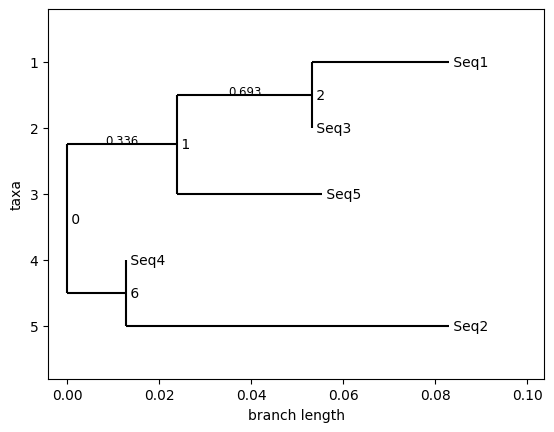

In [40]:
estimated_tree = create_tree(input_sequences)
(
    single_columns_probability, 
    paired_columns_probability,
    leaf_order,
) = get_columns_probability(
    estimated_tree,
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences, 
)

___

## Build First Grammar And Sequence

In [41]:
total_sequence, columns = get_total_sequence(input_sequences, leaf_order)

extend_grammar(
    columns,
    pcfg,
    single_columns_probability, 
    paired_columns_probability,
    filename="./outputs/Extended"
)

## Run First Parsing

In [42]:
# Read from extended file
extended_pcfg = PCNF("./outputs/Extended.cfg", "./outputs/Extended.pcfg")

# Run CYK algorithm
prob, table = extended_pcfg.sentence_prob(total_sequence)
print("Alignment probability:", prob)

Alignment probability: 1.907689818065506e-38


## First Output

Predicted Structure: .......((((((................))))))


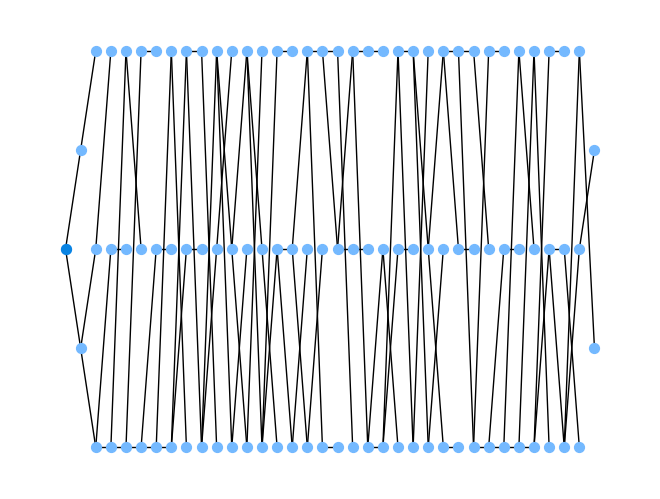

In [43]:
predicted_struct = {}

# Go throw parse table
draw_parse_tree(table, 1, len(list(input_sequences.values())[0]))

structure = ""
for key, val in predicted_struct.items():
    structure += val
print("Predicted Structure:",structure)

___

## Build Second Grammar And Sequence

In [44]:
_input_sequences, _input_sequences__ = remove_pairs(input_sequences, structure)
# _, _columns = get_total_sequence(_input_sequences, leaf_order)

_total_sequence__, _columns = get_total_sequence(_input_sequences__, leaf_order)

extend_grammar(
    _columns,
    pcfg,
    single_columns_probability, 
    paired_columns_probability,
    filename="./outputs/Extended_"
)

extended_pcfg = PCNF("./outputs/Extended_.cfg", "./outputs/Extended_.pcfg")

## Run Second Parsing

In [45]:
# Run CYK algorithm
prob, table = extended_pcfg.sentence_prob__(_total_sequence__)
print("Alignment probability:", prob)

Alignment probability: 1.878773211105935e-29


## Second Output

Predicted Structure: (((((..)))))...........


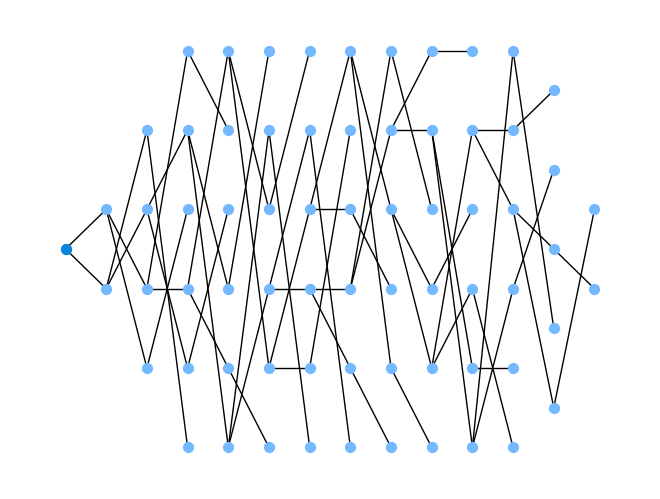

In [46]:
predicted_struct = {}

draw_parse_tree(table, 1, len(list(_input_sequences.values())[0]))

_structure = ""
for key, val in predicted_struct.items():
    _structure += val
print("Predicted Structure:",_structure)

___

## Merge Results

In [47]:
full_structure = ""
inner = 0
for index, char in enumerate(structure): 
    if char == ".":
        if _structure[inner] == "(":
            full_structure += "["
        elif _structure[inner] == ")":
            full_structure += "]"
        else:
            full_structure += "."
        inner += 1
    else:
        full_structure += structure[index]
full_structure

'[[[[[..((((((]]]]]...........))))))'

---